# **CNN-2** 
This notebook is for the 2nd CNN run. Sobel filter pre-processing function is applied to the images, *samplewise_center* and *samplewise_std_normalization* are both set to True.

Optimizer: ADAM

Batch size: 64

Image size: 64 x 64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras as keras
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.layers import add

# To retrieve files/pathnames matching a specified pattern
import glob

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

# Setting seed for reproducibiltiy
import random
SEED = 42
keras.utils.set_random_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [1]:
# Set train and test directories
TRAIN_DIR = '/content/drive/MyDrive/ASL_Dataset/Train'
TEST_DIR = '/content/drive/MyDrive/ASL_Dataset/Test'

In [ ]:
# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
test_df = load_images(TEST_DIR)

In [ ]:
batch_size = 64
image_size = 64
num_class = len(train_df['label'].unique())

In [ ]:
# Sobel filter pre-processing function
from skimage.filters import sobel, scharr
import cv2

def preprocess_image(image):
    '''Function that will be implied on each input. The function
    will run after the image is resized and augmented.
    The function should take one argument: one image (Numpy tensor
    with rank 3), and should output a Numpy tensor with the same
    shape.'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

In [ ]:
# X_training data from a directory
# Sub-directory in that directory will be used as a class for each object
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   horizontal_flip=False,
                                   preprocessing_function=preprocess_image
                                   )

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset='training',
                        shuffle=True)

Found 116101 images belonging to 28 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset='validation',
                        shuffle=True)

Found 49728 images belonging to 28 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

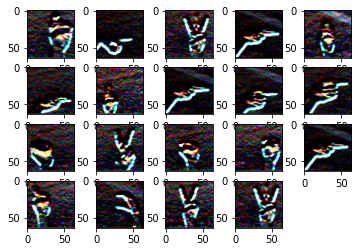

In [ ]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 5
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [ ]:


input_shape = [image_size,image_size,3]
output_shape = 28

input = Input(shape=(input_shape[0], input_shape[1],input_shape[2]))

conv2d_1 = Conv2D(64, kernel_size=4, strides=1, activation='relu')(input)
conv2d_2 = Conv2D(64, kernel_size=4, strides=2, activation='relu')(conv2d_1)
dout_1 = Dropout(0.5)(conv2d_2)

conv2d_3 = Conv2D(128, kernel_size=4, strides=1, activation='relu')(dout_1)
conv2d_4 = Conv2D(128, kernel_size=4, strides=2, activation='relu')(conv2d_3)
dout_2 = Dropout(0.5)(conv2d_4)

conv2d_5 = Conv2D(256, kernel_size=4, strides=1, activation='relu')(dout_2)
conv2d_6 = Conv2D(256, kernel_size=4, strides=2, activation='relu')(conv2d_5)

flatten = Flatten()(conv2d_6)

dout_3 = Dropout(0.5)(flatten)

dense_1 = Dense(512, activation='relu')(dout_3)

output = Dense(28, activation = 'softmax')(dense_1)

model = Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 61, 61, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        65600     
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       131200    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       262272    
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 128)       0     

In [ ]:
# Compile the model

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# Start the training process
history = model.fit(train_generator, validation_data= val_generator, epochs = 10)

Epoch 1/10
1815/1815 [==============================] - 28849s 16s/step - loss: 0.2755 - accuracy: 0.9174 - val_loss: 0.1006 - val_accuracy: 0.9742
Epoch 2/10
1815/1815 [==============================] - 5976s 3s/step - loss: 0.0520 - accuracy: 0.9863 - val_loss: 0.0891 - val_accuracy: 0.9763
Epoch 3/10
1815/1815 [==============================] - 5893s 3s/step - loss: 0.0440 - accuracy: 0.9899 - val_loss: 0.1053 - val_accuracy: 0.9775
Epoch 4/10
1815/1815 [==============================] - 5910s 3s/step - loss: 0.0445 - accuracy: 0.9917 - val_loss: 0.0945 - val_accuracy: 0.9828
Epoch 5/10
1815/1815 [==============================] - 5878s 3s/step - loss: 0.0401 - accuracy: 0.9934 - val_loss: 0.1725 - val_accuracy: 0.9803
Epoch 6/10
1815/1815 [==============================] - 5911s 3s/step - loss: 0.0505 - accuracy: 0.9933 - val_loss: 0.3464 - val_accuracy: 0.9710
Epoch 7/10
1815/1815 [==============================] - 5890s 3s/step - loss: 0.0724 - accuracy: 0.9927 - val_loss: 0.2720

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


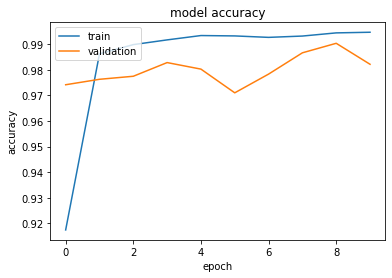

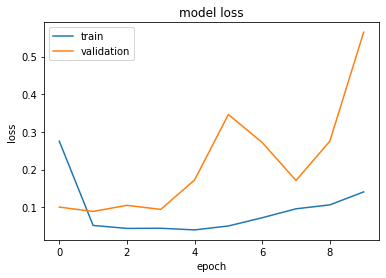

In [ ]:
# Show learning curves

print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save model for future use
model.save('/content/drive/MyDrive/ASL_Dataset/cnn-4-final.h5')